# Simulating a Dipole Antenna

In this computational essay I will be simulating the output of a dipole antenna using two rotating opposite charges. The signal will be the voltage they cause a at a certain point in space, relative to infinitely far away (V=0). The dipole will be rotating around the origin in 2D space. The speed of the rotation will determine the frequency of the measured signal. 

![intro1](pics/intro1.png)

Defining some values and importing the libraries.

In [123]:
import numpy as np
import matplotlib.pyplot as pl

e = 1.602176634e-19 # absolute value of the charges
eps0 = 8.8541878128e-12 # vacuum permittivity

chargesLoc = np.array([[-1, 0], [1, 0]]) #the position of the charges
Q = [-e, e] # value of charges
measurePoint = np.array([0, 50]) # where the signal is measured

The signal will be measured 5000 times a second (sample rate) and this will also define what a second is.

In [88]:
sampleRate = 5000 # defines time

The rotating dipole will produce sinusoidal waves. Lets say we need to make a wave with a frequency of 100Hz. Then the dipole needs to rotate once every 1/100 seconds. But a second is 5000 measurements, or frames lets call them. So 100Hz is one rotation every (1/100) * 5000 frames.

The function to measure voltage at point in space using the formula for electric potential from a point charge. $V = kq/r$

In [89]:
def getVoltageAt(Q, R, at):
    # Q array of charge values
    # R array of positions of charges
    # at point
    k = 1 / (4 * np.pi * eps0)
    return sum([k * q / np.linalg.norm(at - r) for q, r in zip(Q, R)])

Now to create a signal. Spin will be a list of values on the form [frequency, how long]

In [90]:
def spinAndMeasure(Q, Rch, spin, at):
    
    # Q charge values
    # Rch position of charges
    # spin  [freq, duration]
    # at - point of measurement

    measured = []
    for freq, t in spin:

        dth = 2 * np.pi / (sampleRate / freq)  # dTheta per frame

        # rotation matrix, counter-clockwise
        Rot = np.array([[np.cos(dth), -np.sin(dth)], [np.sin(dth), np.cos(dth)]])

        # how many frames/loops
        for i in range(int(t * sampleRate)): # frames = time * sample rate
            measured.append(getVoltageAt(Q, Rch, at)) # measure
            Rch = Rot @ Rch # rotate

    return measured

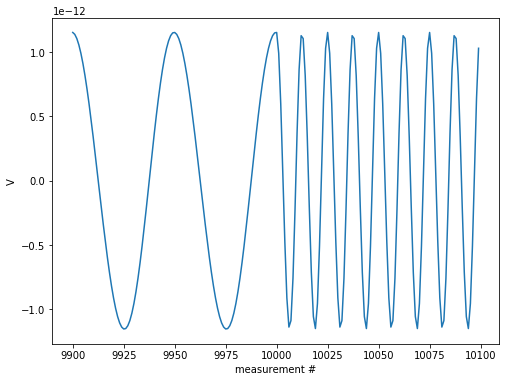

In [120]:
# and to visualize a part of the data

spin = np.array([[100.0, 2.0], [400.0, 3.0], [200.0, 1.0]])

# switches from 100Hz to 400 at frame 10k
data = spinAndMeasure(Q, chargesLoc, spin, measurePoint)[9900:10100] 

x = range(9900, 10100)

pl.figure(figsize=(8,6))
pl.plot(x, data); pl.ylabel("V"); pl.xlabel("measurement #")
pl.show()

In spinAndMeasure both contributions to total voltage from q1 and q2 where added simultaneously. Now how would this change if we introduced the speed of light ? Instead of instantly calculating the voltage, how about adding a delay, a travel time, to when it arrives at the measure point. The delay would be distance/speed. So instead of appending values to measured[], each voltage contribution gets a delay attached to it, and when this time expires the voltage gets added. "Time" here is, of course, frames.

In [121]:
def spinAndMeasureDelay(Q, Rch, spin, at, c):

    measured = []
    DelayVals = []

    # every charge gets its own list of [delay, value] variables
    for i in range(len(Q)):
        DelayVals.append([])

    for freq, t in spin:

        dth = 2 * np.pi / (sampleRate / freq)  # dTheta per frame

        # rotation matrix
        Rot = np.array([[np.cos(dth), -np.sin(dth)], [np.sin(dth), np.cos(dth)]])

        # how many frames/loops
        for i in range(int(t * sampleRate)):

            # for every q calculate the delay and value of voltage
            # add it to DelayVals
            for j in range(len(Q)):
                timeDelay = (np.linalg.norm(Rch[j] - at) / c) * sampleRate
                DelayVals[j].append([timeDelay, getVoltageAt([Q[j]], [Rch[j]], at)])

            measured.append(0.0)

            toBeCleaned = []

            for val in DelayVals:
                for l in range(len(val)):
                    if val[l][0] <= 0:  # signal has arrived
                        measured[-1] += val[l][1]  # add val to main array
                        toBeCleaned.append(l)
                    else:
                        val[l][0] -= 1  # time ticks down

                for l in toBeCleaned:
                    del val[l]
                toBeCleaned.clear()

            Rch = Rot @ Rch

    return measured

The simulated delay wont be very presise since time here moves in units of 1 frame, rounded up. So if the initial delay is 0.1 frames thats as if it were 1. Any effect that delay can have on the measurement is amplified just a bit. But lets compare this model with the instant one.

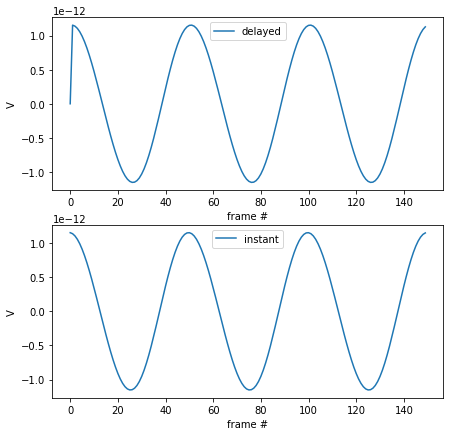

Delayed value at frame 91: 3.6993215621436464e-13
Instant value at frame 90: 3.6993215621436464e-13


In [122]:
end=150

data1 = spinAndMeasureDelay(Q, chargesLoc, spin, measurePoint, 300_000_000)[:end]
x = range(end)

data2 = spinAndMeasure(Q, chargesLoc, spin, measurePoint)[:end] 

pl.figure(figsize=(7, 7))
pl.subplot(211)
pl.plot(x, data1, label="delayed")
pl.ylabel("V"); pl.xlabel("frame #"); pl.legend()

pl.subplot(212)
pl.plot(x, data2, label="instant")
pl.ylabel("V"); pl.xlabel("frame #"); pl.legend()
pl.show()

print(f"Delayed value at frame 91: {data1[91]}")
print(f"Instant value at frame 90: {data2[90]}")

Practically no difference. Only a frame of delay that frame comes from rounding up from 0.000833. The charges are 2m away from each other and the measure point 50m away from their center. This is expected. Now what if we slow down the speed of light and move the charges and the measure point a little farther from each other ?

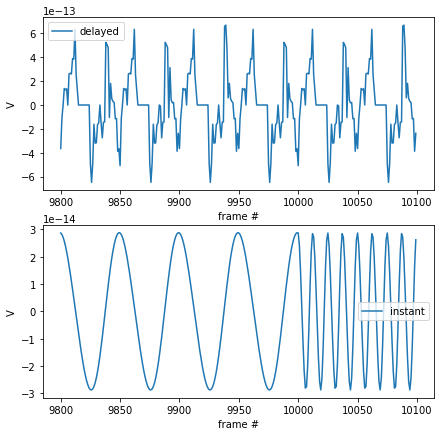

In [105]:
chargesLoc = np.array([[1000, -1000], [-1000, 1000]])
measurePoint = np.array([0, 10000])

a = 9800
b = 10100

data1 = spinAndMeasureDelay(Q, chargesLoc, spin, measurePoint, 300_000)[a:b]
x = range(a, b)

data2 = spinAndMeasure(Q, chargesLoc, spin, measurePoint)[a:b] 

pl.figure(figsize=(7, 7))
pl.subplot(211)
pl.plot(x, data1, label="delayed")
pl.ylabel("V"); pl.xlabel("frame #"); pl.legend()

pl.subplot(212)
pl.plot(x, data2, label="instant")
pl.ylabel("V"); pl.xlabel("frame #"); pl.legend()
pl.show()


We can see the the delayed version still hasnt caught up to the change in frequency, and its wave seems quite weird indeed.

Now how can these rotating charges be used to generate something other than sine waves? Lets see how their individual signals look like from a point (0, 50).

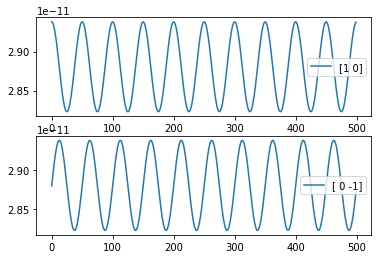

In [114]:
Q1 = [e]
R1 = np.array([1, 0])

Q2 = [e]
R2 = np.array([0, -1])

freq = [[100, 0.1]]

data1 = spinAndMeasure(Q1, R1, freq, [0, 50])
data2 = spinAndMeasure(Q2, R2, freq, [0, 50])

x = range(len(data1))

pl.subplot(211)
pl.plot(x, data1, label=f"{R1}"); pl.legend()
pl.subplot(212)
pl.plot(x, data2, label=f"{R2}"); pl.legend()
pl.show()

Now those look like cos and sin functions, respectively. The speed of rotation can be seen as a scaling factor for the variable inside. If lets say 100Hz is the standard, call it cos(x), 200Hz would be cos(2x).

So by picking the speed of rotation, and where (more probably when) the charges start rotating we can produce waves that look like


![cossin](pics/cossin.png)

With linear combinations of these function we can interpolate (more functions -> more points) any single-valued function on an interval [a, b] if we set $\omega=\frac{2\pi}{b-a}$ and the value of the charges would then be coefficients in front of the functions.